# TA Analysis - Template

Hooray! You're ready to analyse your data. Make sure this file and the TA master script (dataPrepTAv12 - number will almost definitely change) are in the folder your data files are in.


REMEMBER for any functions, CTRL + CLick to see function or hover over to see arguments

In [21]:
#Import packages
import os
from dataPrepTAv13 import *
import matplotlib.pyplot as plt
import datetime

#### Fluence Calculations

In [22]:
carrier_dens, power_dens, energy_dens = calc_fluences(P=[2,10,50,250],d = 250, WL = 532, areaType = 'gauss',di=2334,a=2500,b=1950)
print(carrier_dens)

Carrier Densities in cm⁻³ = [9013624868965802.0, 4.5068124344829016e+16, 2.2534062172414506e+17, 1.1267031086207254e+18]
Power fluence in μWcm⁻² = [46.74534946442634, 233.7267473221317, 1168.6337366106584, 5843.168683053293]
Energy fluence in nWcm⁻² = [0.09349069892885267, 0.4674534946442634, 2.337267473221317, 11.686337366106585]
[9013624868965802.0, 4.5068124344829016e+16, 2.2534062172414506e+17, 1.1267031086207254e+18]


#### 1. Select files

In [23]:
series = 'MAPI'
sample = '_1_'  # Choose the common sample name or number
files = [file for file in os.listdir() if file.endswith('.hdf5') and file.startswith(f'{series}')and sample in file]

for index, file in enumerate(files):
    file_path = os.path.join(os.getcwd(), file)
    file_size = os.path.getsize(file_path)  # Get file size in bytes

    # Get file creation time and format it as a string
    file_creation_time = os.path.getctime(file_path)
    creation_time = datetime.datetime.fromtimestamp(file_creation_time).strftime('%Y-%m-%d %H:%M:%S')

    print(f"\033[1m{index}: {file[:-5]}\033[0m")
    print(f"(Size: {file_size} bytes, Created: {creation_time})")
    print(" ")

0: MAPI_1_532nm_12us_2uWrep
(Size: 1021400 bytes, Created: 2023-08-16 16:37:43)
 
1: MAPI_1_532nm_12us_2uWrep_1
(Size: 30048592 bytes, Created: 2023-08-16 16:37:43)
 
2: MAPI_1_532nm_15us_10uW
(Size: 19982400 bytes, Created: 2023-08-16 16:37:43)
 
3: MAPI_1_532nm_15us_250uW
(Size: 1161120 bytes, Created: 2023-08-16 16:37:43)
 
4: MAPI_1_532nm_15us_2uWcheck
(Size: 1037760 bytes, Created: 2023-08-16 16:37:43)
 
5: MAPI_1_532nm_15us_50uW
(Size: 7631584 bytes, Created: 2023-08-16 16:37:43)
 
6: MAPI_1_532nm_3us_2uW
(Size: 25265600 bytes, Created: 2023-08-16 16:37:43)
 


#### 2. Reorder and exclude files

In [24]:
new_order = [6,2,5,3]
files = [files[i] for i in new_order]
for index, file in enumerate(files):
    print(f" {index}: {file[:-5]}")

 0: MAPI_1_532nm_3us_2uW
 1: MAPI_1_532nm_15us_10uW
 2: MAPI_1_532nm_15us_50uW
 3: MAPI_1_532nm_15us_250uW


#### 3. Convert hdf5 files to 3D or 2D arrays

In [25]:
arr3ds = []
arr2ds = []
print('\033[1mFor 3D arrays:\033[0m')
print('Shape = (Sweep, Timepoints, Wavelength)')
print('\033[1mFor 2D arrays:\033[0m')
print('Shape = (Timepoints, Wavelength)')
print(' ')
for f in files:
    print(f'\033[1m'+f[:-5]+'\033[0m')
    arr3d = import_hdf5(f)
    arr3ds.append(arr3d)
    print('3D array shape:',arr3d.shape)
    arr2d = mean_sweeps(arr3d)
    arr2ds.append(arr2d)
    print('2D array shape:',arr2d.shape)
    print(' ')


For 3D arrays:
Shape = (Sweep, Timepoints, Wavelength)
For 2D arrays:
Shape = (Timepoints, Wavelength)
 
MAPI_1_532nm_3us_2uW
3D array shape: (95, 117, 257)
2D array shape: (117, 257)
 
MAPI_1_532nm_15us_10uW
3D array shape: (67, 132, 257)
2D array shape: (132, 257)
 
MAPI_1_532nm_15us_50uW
3D array shape: (25, 132, 257)
2D array shape: (132, 257)
 
MAPI_1_532nm_15us_250uW
3D array shape: (3, 132, 257)
2D array shape: (132, 257)
 


#### 4. Plot spectrum at t=1 to find bleach wavelengths <a id='4'></a>

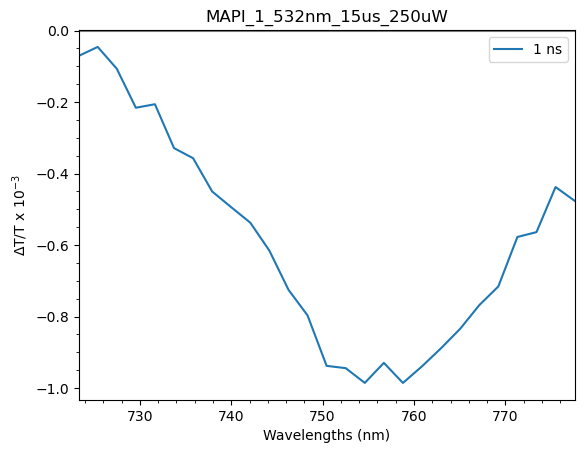

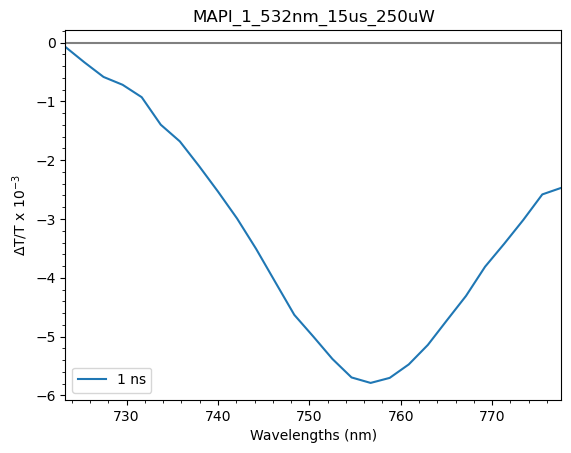

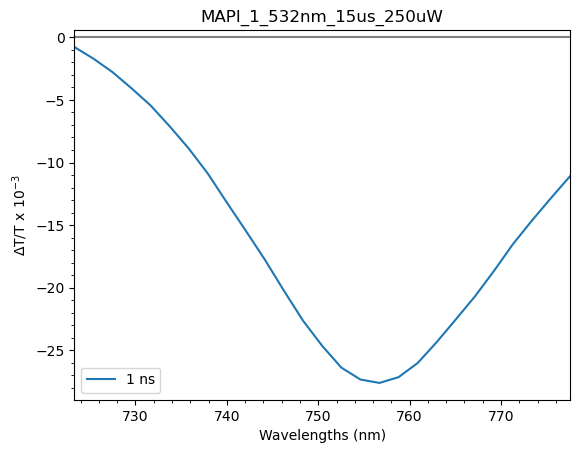

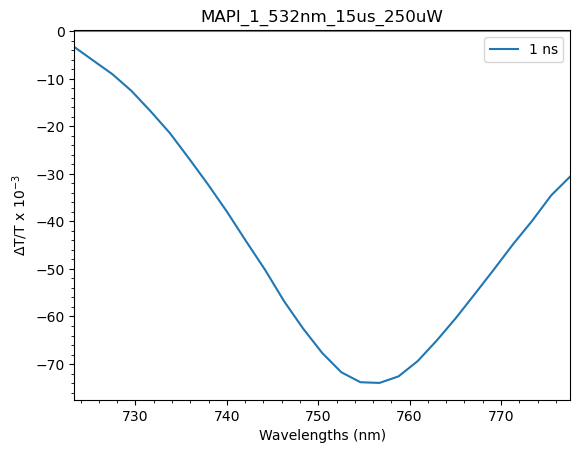

In [26]:
wlmin= 175
wlmax= -55
for arr in arr2ds:
        plot_spec(arr,wlmin=wlmin,wlmax=wlmax,title=f[:-5])
plt.show()
# t=1 is default, can select others 

#### 5. Check all individual sweeps for t=0 drift or large noise spikes

If it looks fine, skip ahead to [7](#7), if not use [6](#6) to align the rise. If this doesn't make sense, got back to [4](#4) to check you have the positive bleach.

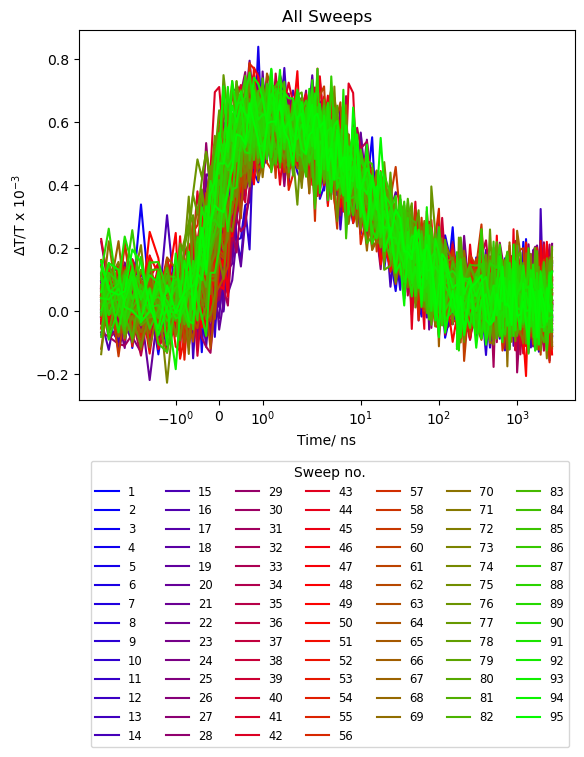

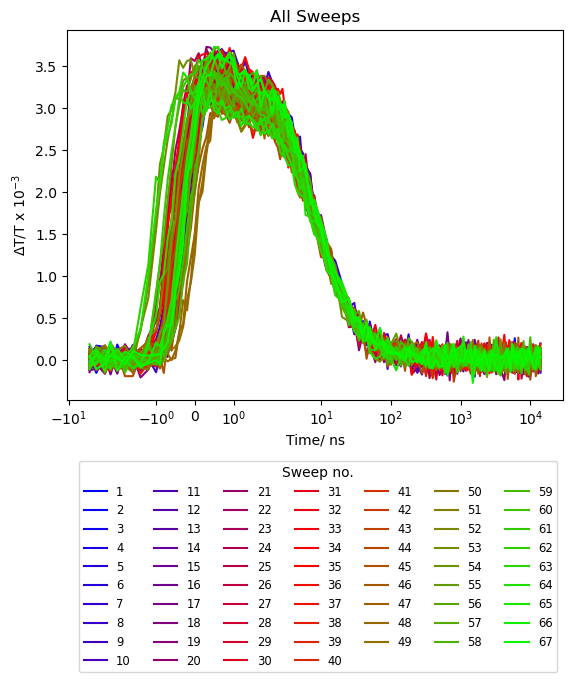

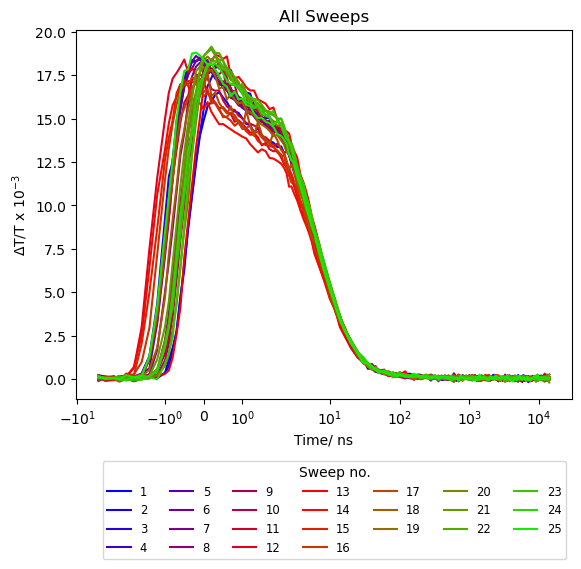

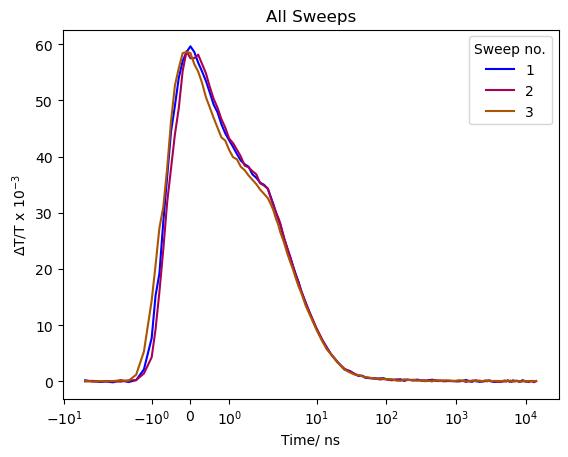

In [33]:
all_decays = []
for arr in arr3ds:
    alls = sweep_decays(arr,wlmin=wlmin,wlmax=wlmax, x = 1000,remove_zeros=False,constant=1e-4)
    all_decays.append(alls)
# Bleach should be positive - try adjusting x if it is the wrong sign
# Noise spikes to zero (acquistion error) are taken care of with remove_zeros argument as True

#### 6. <a id='6'></a> Align Rise

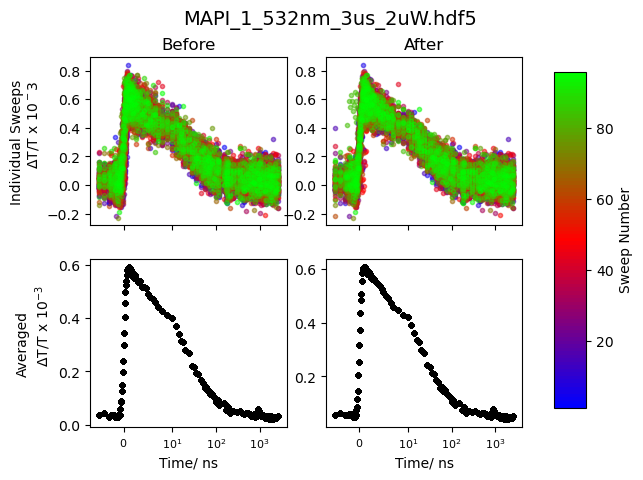

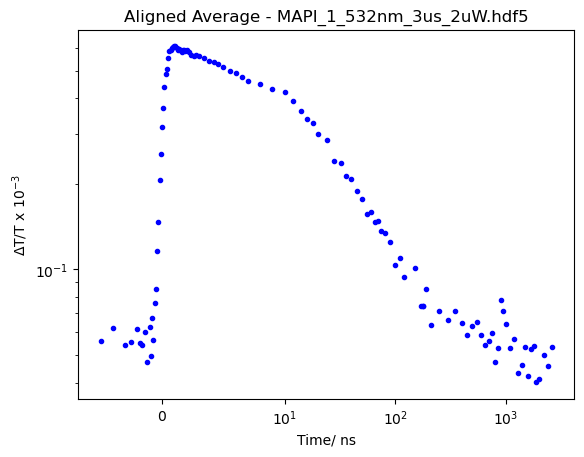

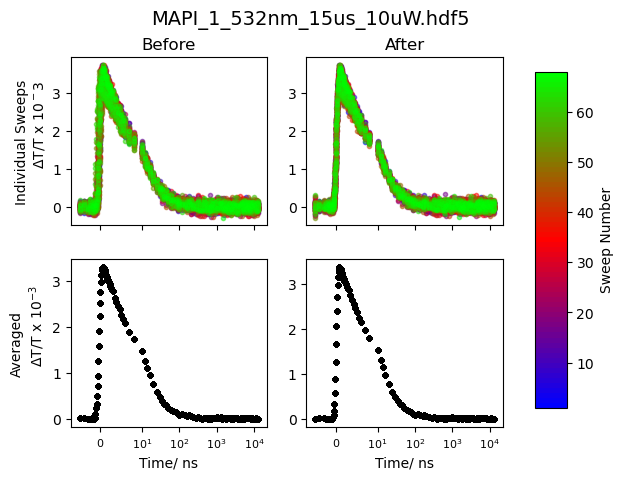

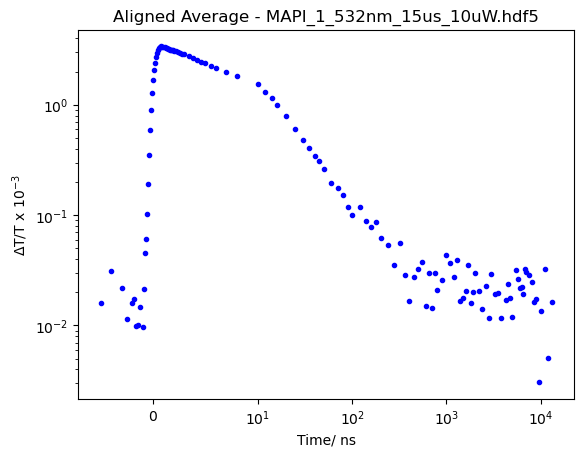

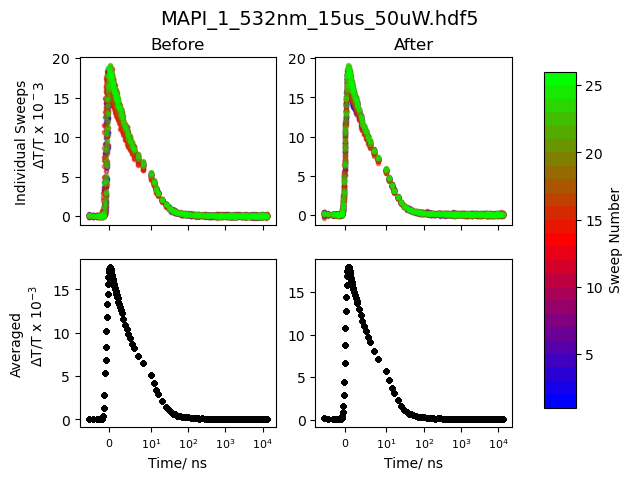

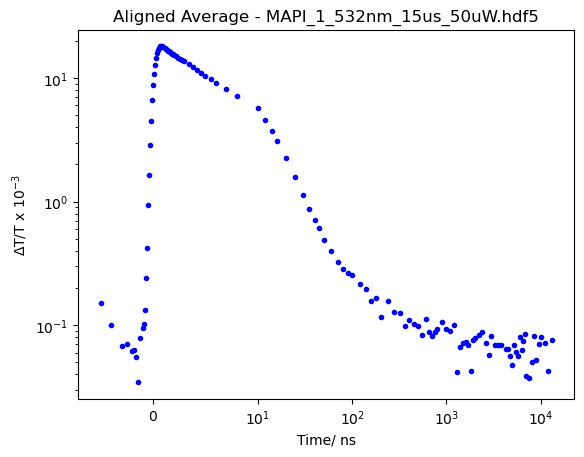

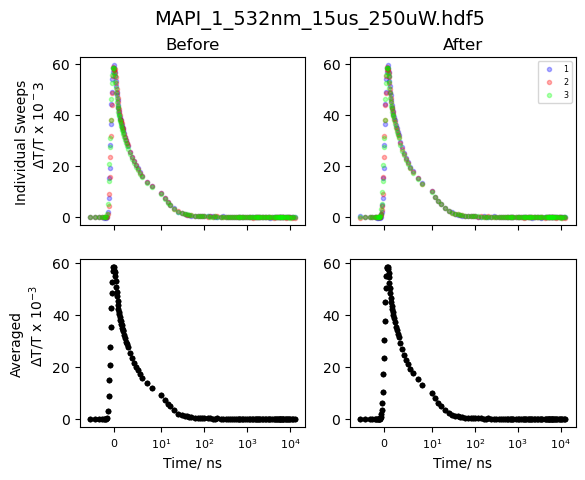

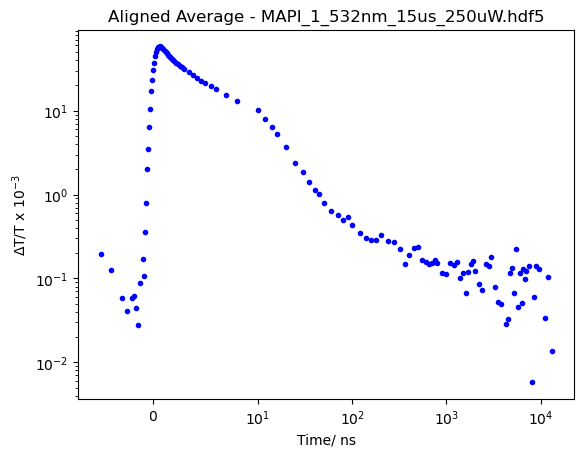

In [39]:
# Alignment of rises due to t=0 drift only use with good = False from last step
aligned_decays = []
for i,f in zip(all_decays,files):
    aligned = align_rise(i,name=f,endTime=-1)
    aligned_decays.append(aligned)

#### 7. Average Signal <a id='7'></a>

4
(2, 115)
(2, 130)
(2, 130)
(2, 130)


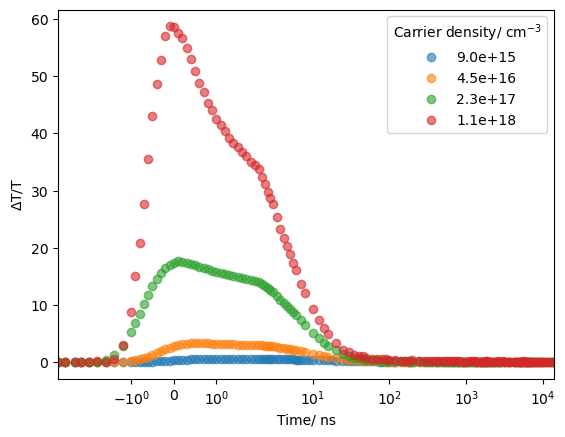

In [40]:
fig,ax = plt.subplots()
print(len(aligned_decays))
average_decays = []
for arr2d, c in zip(arr2ds, carrier_dens):
    av = average_decay(arr2d,ax=ax, wlmin=wlmin, wlmax=wlmax, label = f'{c:.1e}',legendTitle=f'Carrier density/ cm$^{{-3}}$',tcorrect=False, x=1000)
    print(av.shape)
    average_decays.append(av)

[[-5.00000000e+00 -4.00000000e+00 -3.00000000e+00 -2.50000000e+00
  -2.00000000e+00 -1.80000000e+00 -1.60000000e+00 -1.40000000e+00
  -1.20000000e+00 -1.00000000e+00 -9.00000000e-01 -8.00000000e-01
  -7.00000000e-01 -6.00000000e-01 -5.00000000e-01 -4.00000000e-01
  -3.00000000e-01 -2.00000000e-01 -1.00000000e-01  0.00000000e+00
   1.00000000e-01  2.00000000e-01  3.00000000e-01  4.00000000e-01
   5.00000000e-01  6.00000000e-01  7.00000000e-01  8.00000000e-01
   9.00000000e-01  1.00000000e+00  1.10000000e+00  1.20000000e+00
   1.30000000e+00  1.40000000e+00  1.50000000e+00  1.60000000e+00
   1.70000000e+00  1.80000000e+00  1.90000000e+00  2.00000000e+00
   2.20000000e+00  2.40000000e+00  2.60000000e+00  2.80000000e+00
   3.00000000e+00  3.40000000e+00  3.80000000e+00  4.20000000e+00
   4.60000000e+00  5.00000000e+00  5.50000000e+00  6.00000000e+00
   6.50000000e+00  7.00000000e+00  8.00000000e+00  9.00000000e+00
   1.00000000e+01  1.20000000e+01  1.40000000e+01  1.60000000e+01
   1.80000

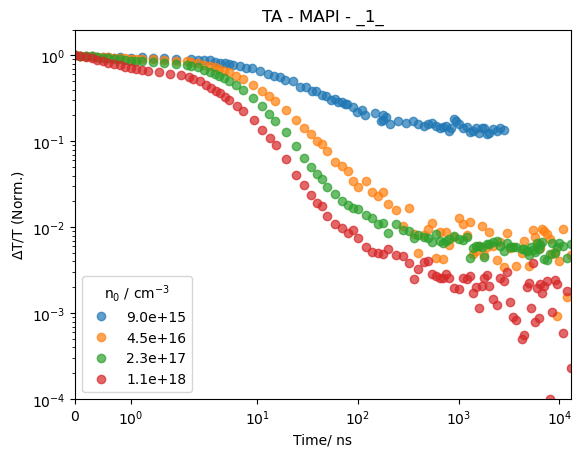

In [110]:
# Plot your average signals normalised or not

fig,ax =plt.subplots()
constant = 1e-4
use_signals = [average_decays[0],aligned_decays[1],aligned_decays[2],aligned_decays[3]]
#print(use_signals[0])

#I chose the aligned decays for the two higher fluences as it actually works on them
#But chosen the unaligned version of the lowest fluence as it just looks messed up
decays = []

normalise_decay = True #Choose whether you want decay normalised to 1
carrier_decay = False #Choose whether you want to multiply the decay by the carrier density
                     #(only works if normalise_decay = True)
                     
shifts = [0,0,0,0]
max_signal_total = np.max(use_signals[3][1,:])

for sig, c,s in zip(use_signals, carrier_dens, shifts):
    
    max_signal = sig[1,:].argmax()

    signal = sig[1,max_signal:]
    signal_adjusted = signal + abs(signal.min()) + constant
    time = sig[0, max_signal:] - sig[0,max_signal] + s
    
    if normalise_decay:
        signal = signal_adjusted / signal_adjusted[0]
        ax.set_ylim(constant, 2)
        ax.set_ylabel(f'$\Delta$T/T (Norm.)')
        if carrier_decay:
            signal = signal * c
            ax.set_ylim(signal[-1]*0.0075, signal[0]*1.1)
            ax.set_ylabel(f'n/ cm$^3$')
    else:
        ax.set_ylabel(f'$\Delta$T/T x 10$^{{-3}}$')
    
    
    ax.plot(time, signal, 'o', label=f'{c:.1e}',alpha=0.7)
    ax.set_xscale('symlog')
    ax.set_xlim(0,time[-1])
    if not (carrier_decay and normalise_decay):
        ax.legend(title=f'n$_0$ / cm$^{{-3}}$') 
    ax.set_xlabel('Time/ ns')
    ax.set_yscale('log')
    ax.set_title(f'TA - {series} - {sample}')
    decay = np.array((time, signal))
    #decays.append(decay)
    #plt.show()


In [37]:
#Save data
save_TA_data(f'{series}_{sample}_TADecays.py',decays)